# 1.Load the Data

In [2]:
#impoart libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import re
import string
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import  f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from itertools import product

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#load the data
df = pd.read_csv('Combined Data.csv', index_col=0)

In [5]:
#Drop NULLs
df.dropna(inplace = True)

In [6]:
df.shape

(52681, 2)

In [7]:
df.describe().T

,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,52681,7,Normal,16343


In [8]:
#As we are going to do binary classifications here, turn all mentl health issues to '1' and normal to 0
df['status'] = df['status'].apply(lambda x: 1 if x != "Normal" else 0)

In [ ]:
# #shuffle the data
# random.seed(1234)
# df = shuffle(df)
# df

,statement,status
33186,"well, a d is better than an f.",0
26373,"I do not really want to die, I just want the p...",1
9387,I know how you feel. You feel as the world doe...,1
9626,"Ever since the summer solstice, I have had thi...",1
48391,mid 40s anxiety at work I dread going to work ...,1
...,...,...
23400,I think I have depression and anxiety I do not...,1
46570,I am spiraling. Yesterday my panic attack last...,1
8763,Or is it just me?? Like I am crying rn and its...,1
10799,"Sometimes I just want to escape, I do not know...",1


After bacis cleaning dropping the NULLs, the data contains 52681 records with 2 columns, statement \(text\) and status \(status\) .
There are 7 unique status, as we are going to do binary classification here, we turn all mentl health issues to '1' and normal to 0

# 3.Modeling

## 3.1 Classical ML Models


### 3.1.0 Pre-processing for classical ML Models

In [9]:
#make a copy of data especially for classical ML Models
df1 = df.copy()

In [10]:
# Step 1: Clean the Text
# Purpose: Removes noise (e.g., special characters, extra spaces) that doesn't contribute to understanding the text's meaning.
def clean_text(text):
    """Cleans input text from social media for NLP models.

    Args:
        text (str): The input text.

    Returns:
        str: The cleaned text.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df1['statement'] = df1['statement'].apply(clean_text)

In [11]:
#Step 2: stopwords removal
#Stop words (e.g., "and", "is", "the") do not carry much meaning and can be removed to reduce noise.
stop_words = set(stopwords.words('english'))
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [12]:
#Step 3：lemmatize
# Reduces words to their base or root forms, ensuring that variations of the same word are treated equally (e.g., "running", "runs", "ran" → "run").
lemmatizer = WordNetLemmatizer()
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [13]:
#Step 4: Train-Test Split
#Random sample with seed, use 20% data for test, 60% data for train,20% data for validation
X1 = df1['statement']
y1 = df1['status']

# Initial train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X1.tolist(), y1.tolist(), test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train_1, y_train_1, test_size=0.25, random_state=42  # for validation: 0.25 * 0.8 = 0.2 of original data
)


In [14]:
# Step 5: TF-IDF Vectorization
#Converts raw text into numerical features for input to ML models
import joblib
tfidf = joblib.load("tfidf_vectorizer_1_binary.pkl")
X_train_tfidf_1 = tfidf.transform(X_train_1)  # Fit on training data
X_test_tfidf_1 = tfidf.transform(X_test_1)       # Transform test data

# Initialize the TF-IDF Vectorizer
tfidf = tfidf = joblib.load("tfidf_vectorizer_2_binary.pkl")

# Fit TF-IDF on training data
#tfidf.fit(X_train_1)

# Transform train, validation, and test sets
X_train_1= tfidf.transform(X_train_1)
X_val_1 = tfidf.transform(X_val_1)
X_test_1 = tfidf.transform(X_test_1)


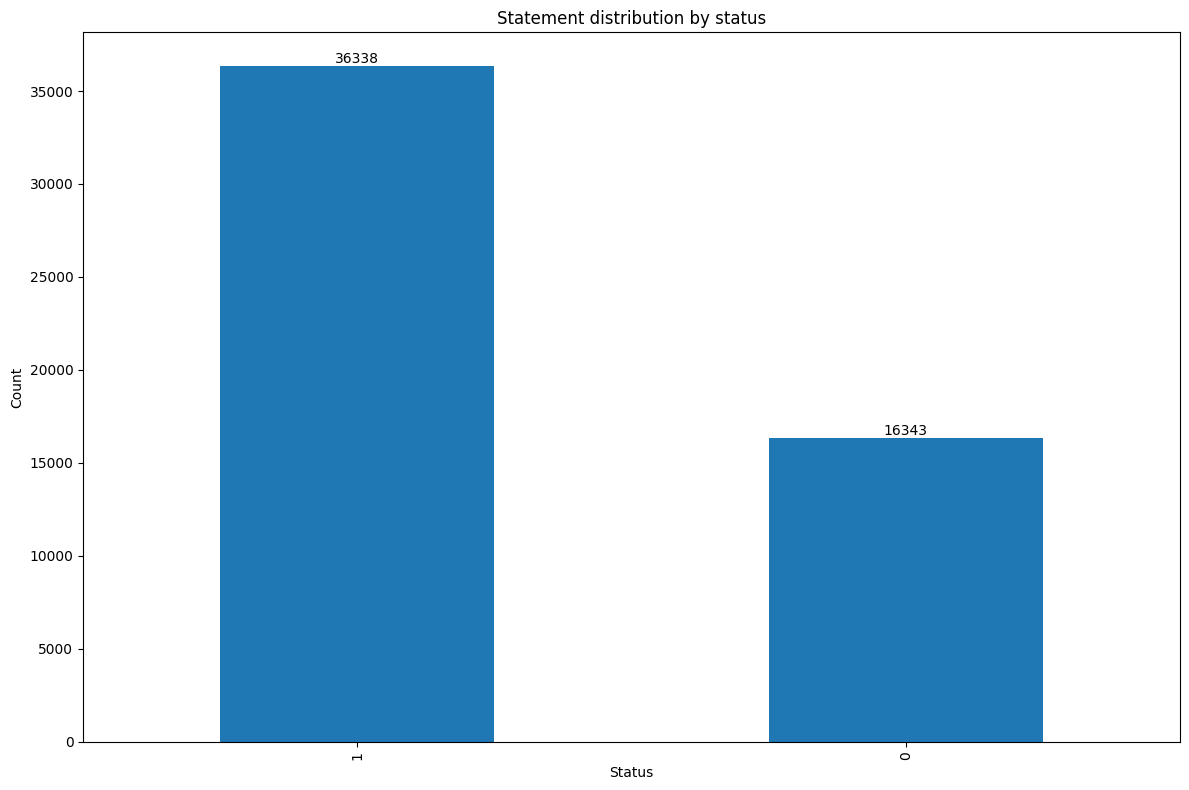

In [ ]:
# As shown by below plot, there are 36338 'abnormal' while just 16343 'normal', which means there are class-imbalance issues
# Therefore, we would need to balance the class distribution in the training, we would try to do this by adjust class weights during training
plt.figure(figsize=(12,8))
status_counts = df1['status'].value_counts()
ax = status_counts.plot(kind='bar')
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
#SMOTE technique used to resample the class - Do not do it - SMOTE is not giving reasonable result
#smote = SMOTE(random_state=42)
#X_train_resampled_1, y_train_resampled_1 = smote.fit_resample(X_train_tfidf_1, y_train_1)

### 3.1.1 SVM

In [ ]:
random.seed(1234)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],           # Regularization strength
    'kernel': ['linear', 'rbf'],    # Kernel types
    'class_weight': ['balanced', None],    # Handle class imbalance
    'gamma': ['scale', 'auto'],            # Kernel coefficient
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through all combinations of parameters
for C, kernel, class_weight, gamma in product(param_grid['C'], param_grid['kernel'], param_grid['class_weight'], param_grid['gamma']):
    try:
        # Create the SVM model with current parameters
        model = SVC(C=C, kernel=kernel, class_weight=class_weight, gamma=gamma, random_state=42)

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')
        print(f"Validation F1-Score for C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {'C': C, 'kernel': kernel, 'class_weight': class_weight, 'gamma': gamma}
    except Exception as e:
        print(f"Skipping combination C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

In [ ]:
SVM = joblib.load("svm_model_binary.pkl")


In [ ]:
# Evaluate the Model on test set, with best parameters found
y_test_pred = SVM.predict(X_test_1)
print("\nTest Performance:")
print(classification_report(y_test_1, y_test_pred))
f1_score(y_test_1, y_test_pred, average='weighted')


Test Performance:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537



0.9416557084656579

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample


def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper


def bootstrap_auc_ci(y_true, y_scores, n_iterations=1000):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    auc_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[indices], y_scores[indices])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)

    ci_lower = np.percentile(auc_scores, 2.5)
    ci_upper = np.percentile(auc_scores, 97.5)
    return np.mean(auc_scores), ci_lower, ci_upper


def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def plot_roc_curve(y_true, y_scores, label_prefix="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label_prefix} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {label_prefix}')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc


def evaluate_model(model, X_test, y_test, model_name="Model", use_proba=False):
    print(f"\n--- Evaluation Report: {model_name} ---\n")

    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred)
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    plot_confusion_matrix(y_test, y_pred)

    # ROC + AUC
    if use_proba:
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci(y_test, y_scores)
    print(f"AUC Score: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_roc_curve(y_test, y_scores, label_prefix=model_name)


# --- Usage Example ---
# For SVM with decision_function:
#evaluate_model(SVM, X_test_1, y_test_1, model_name="SVM", use_proba=False)

# For models like RandomForest or LogisticRegression with predict_proba:
# evaluate_model(rf_model, X_test, y_test, model_name="Random Forest", use_proba=True)



--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9417
95% CI for F1 Score: [0.9371, 0.9461]


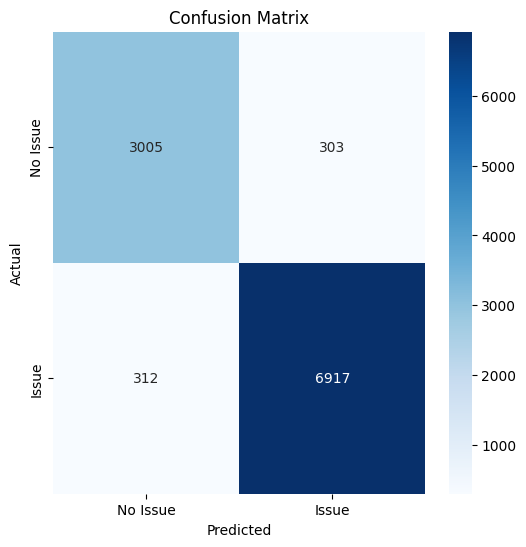

AUC Score: 0.9816
95% CI for AUC: [0.9794, 0.9838]


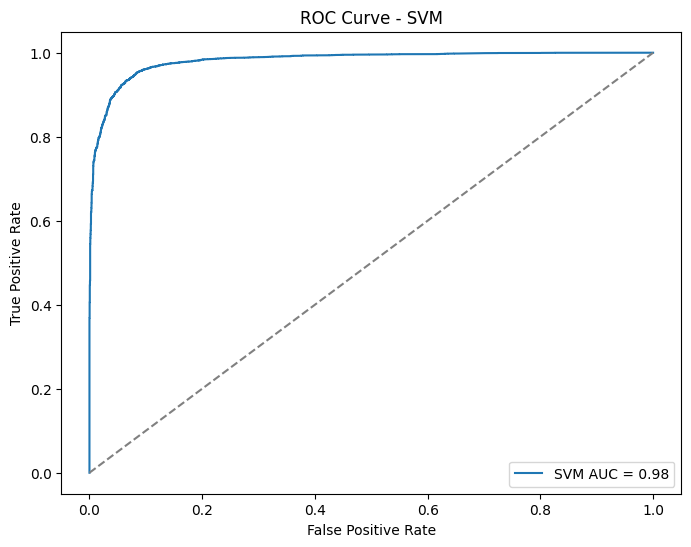

In [ ]:
evaluate_model(SVM, X_test_1, y_test_1, model_name="SVM", use_proba=False)

### 3.1.2 Logistic Regression

In [ ]:
# Define parameter grid

random.seed(1234)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'solver': ['liblinear', 'lbfgs'],   # Optimization algorithms
    'penalty': ['l2'],                  # Regularization type
    'class_weight': ['balanced',None]  # Handle class imbalance - balanced is a choice to adjust class weights according to class frequency
}

# Grid search
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through all combinations of parameters, find the best params that works the best on validation set - primary metric: F1
for C, solver, penalty, class_weight in product(param_grid['C'], param_grid['solver'], param_grid['penalty'], param_grid['class_weight']):
    try:
        # Create the model with current parameters
        model = LogisticRegression(C=C, solver=solver, penalty=penalty, class_weight=class_weight, random_state=42, max_iter=1000)

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred,average='weighted')
        print(f"Validation F1-Score for C={C}, solver={solver}, penalty={penalty}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {'C': C, 'solver': solver, 'penalty': penalty, 'class_weight': class_weight}
    except Exception as e:
        print(f"Skipping combination C={C}, solver={solver}, penalty={penalty}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

In [15]:
LR = LogisticRegression(C=10, solver='lbfgs', penalty='l2', class_weight=None, random_state=42, max_iter=1000)
LR.fit(X_train_1, y_train_1)

LogisticRegression(C=10, max_iter=1000, random_state=42)


--- Evaluation Report: LR ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9362
95% CI for F1 Score: [0.9315, 0.9413]


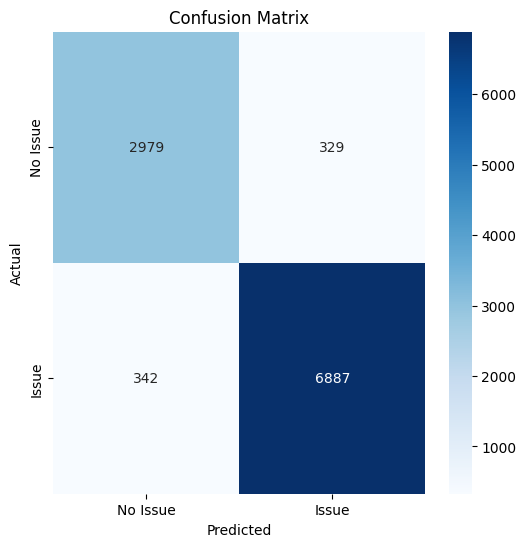

AUC Score: 0.9783
95% CI for AUC: [0.9759, 0.9807]


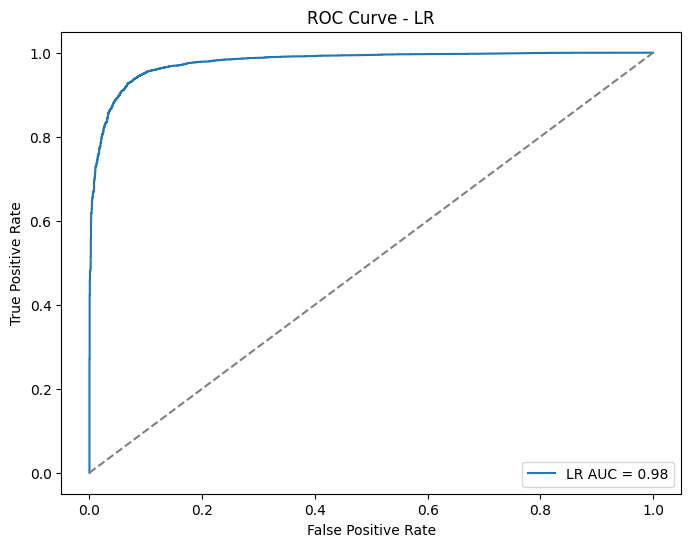

In [ ]:
evaluate_model(LR, X_test_1, y_test_1, model_name="LR", use_proba=True)

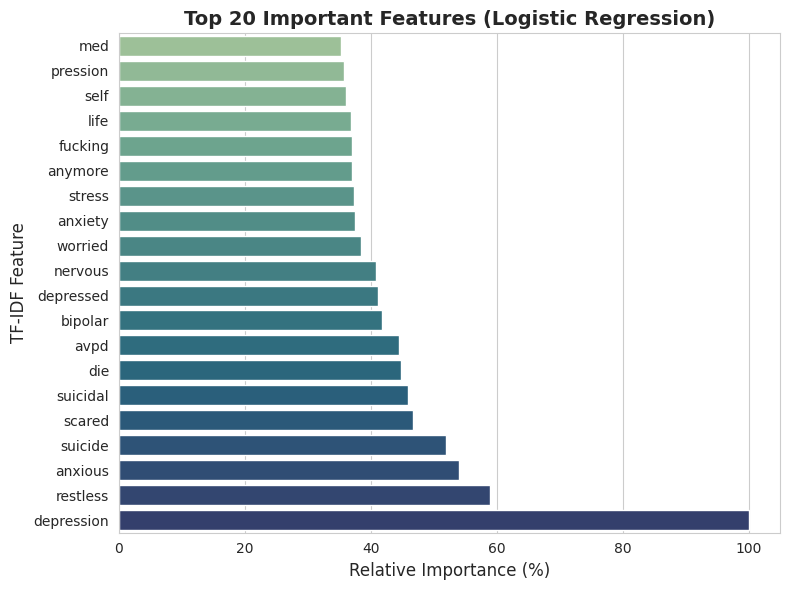

         Feature  Coefficient  Scaled Importance
2287  depression    23.390375         100.000000
7390    restless    13.797117          58.986304
412      anxious    12.645218          54.061632
8587     suicide    12.155925          51.969776
7640      scared    10.909049          46.639050
8584    suicidal    10.729209          45.870187
2388         die    10.477631          44.794627
661         avpd    10.393295          44.434068
896      bipolar     9.792005          41.863397
2282   depressed     9.620275          41.129204
5819     nervous     9.559678          40.870138
9869     worried     9.010162          38.520812
408      anxiety     8.774245          37.512203
8467      stress     8.737335          37.354404
417      anymore     8.676387          37.093833
3615     fucking     8.646679          36.966827
5081        life     8.622465          36.863305
7748        self     8.426424          36.025179
6712    pression     8.345217          35.677997
5422         med    

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract feature names
feature_names = tfidf.get_feature_names_out()

# Extract coefficients from the trained Logistic Regression model
coefficients = LR.coef_[0]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Use absolute value for importance
importance_df['Importance (Abs)'] = importance_df['Coefficient'].abs()

# Normalize importance (rescale to 0–100)
importance_df['Scaled Importance'] = (
    importance_df['Importance (Abs)'] / importance_df['Importance (Abs)'].max()
) * 100

# Sort and take top 20
top_20_features = importance_df.sort_values(by='Importance (Abs)', ascending=False).head(20)

# Plot (horizontal bar chart)
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    x='Scaled Importance',
    y='Feature',
    data=top_20_features[::-1],  # Reverse for descending top-down
    palette="crest"
)

plt.title("Top 20 Important Features (Logistic Regression)", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance (%)", fontsize=12)
plt.ylabel("TF-IDF Feature", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save high-res for paper
plt.savefig("top_features_lr.png", dpi=300)
plt.show()

# Optionally print the top 20
print(top_20_features[['Feature', 'Coefficient', 'Scaled Importance']])


### 3.1.3 Random Forest

In [ ]:
#Define the Hyperparameter Tuning grid
random.seed(1234)

param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees
    'max_depth': [10, 20, None],           # Maximum depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples at a leaf node
    'class_weight': [None, 'balanced']     # Handle class imbalance - balanced is a choice to adjust class weights according to class frequency
}

# Grid search
best_f1 = 0
best_model = None
best_params = None


# Start timer
start_time = time.time()

# Iterate through all combinations of parameters
for n_estimators, max_depth, min_samples_split, min_samples_leaf, class_weight in product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['class_weight']
):
    try:
        # Create the Random Forest model with current parameters
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=42,
            n_jobs=-1
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred,average='weighted')
        print(f"Validation F1-Score for n_estimators={n_estimators}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time


# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

In [17]:
RandomForest = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train the model
RandomForest.fit(X_train_1, y_train_1)


RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=42)


--- Evaluation Report: Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3308
           1       0.94      0.96      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.92      0.92     10537
weighted avg       0.93      0.94      0.93     10537

Weighted F1 Score: 0.9347
95% CI for F1 Score: [0.9299, 0.9397]


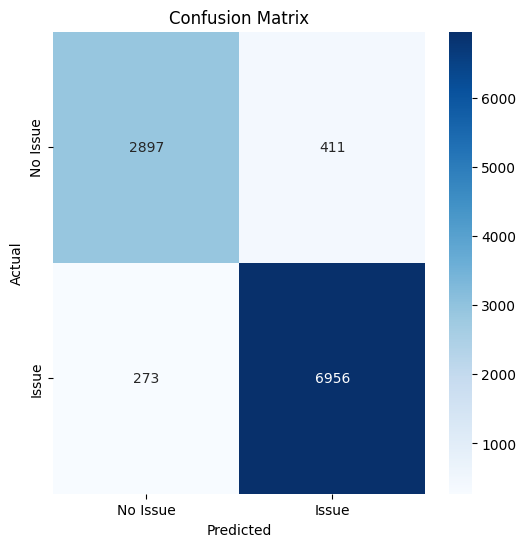

AUC Score: 0.9764
95% CI for AUC: [0.9736, 0.9791]


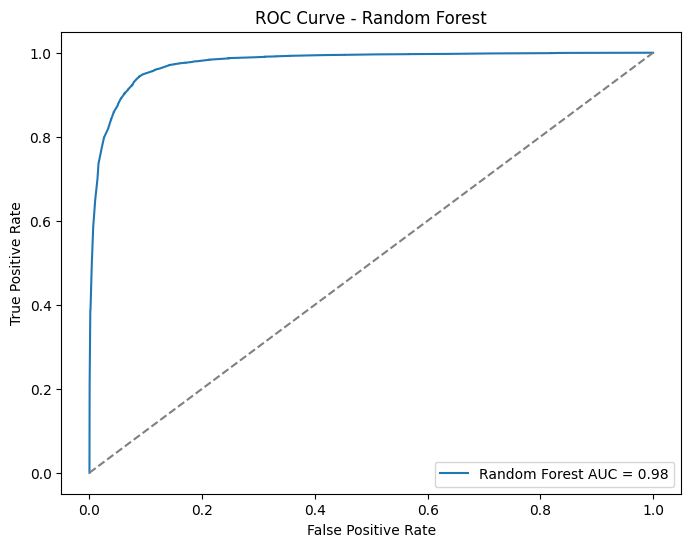

In [ ]:
evaluate_model(RandomForest, X_test_1, y_test_1, model_name="Random Forest", use_proba=True)

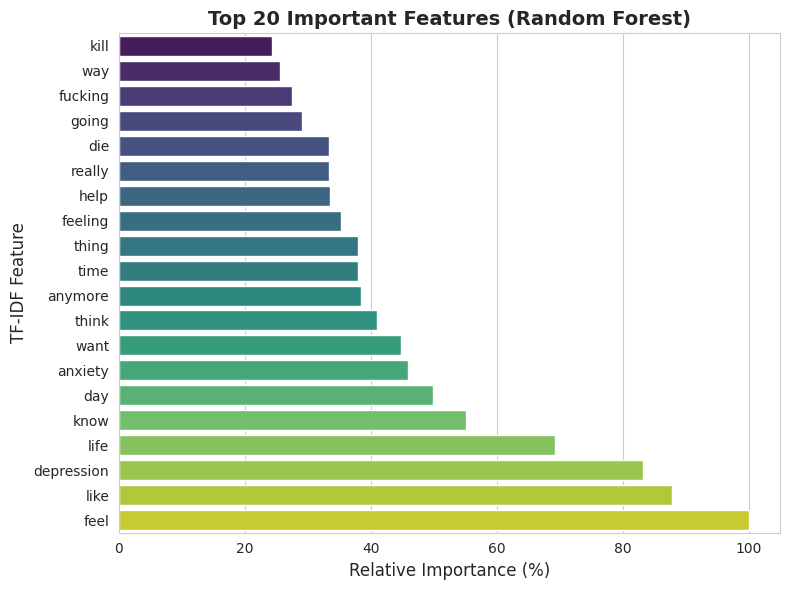

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if RandomForest is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = RandomForest.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (Random Forest)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_rf.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


### 3.1.4 LGBM

In [ ]:
random.seed(1234)

param_grid = {
    'n_estimators': [50, 100],            # Reduced to two options for number of boosting iterations
    'learning_rate': [0.01, 0.1],         # Reduced to two commonly used learning rates
    'max_depth': [-1, 10],                # Focus on unlimited depth (-1) and a typical max depth (10)
    'num_leaves': [31, 50],               # Removed larger values for simplicity
    'min_child_samples': [10, 20],        # Focused on fewer options for minimum child samples
    'class_weight': [None, 'balanced']    # Retained both options for class imbalance handling
}

# Grid search
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through all combinations of parameters
for n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, class_weight in product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['num_leaves'],
    param_grid['min_child_samples'],
    param_grid['class_weight']
):
    try:
        # Create the LightGBM model with current parameters
        model = LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            class_weight=class_weight,
            random_state=42,
            n_jobs=-1,
            importance_type = "gain"
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred,average = 'weighted')
        print(f"Validation F1-Score for n_estimators={n_estimators}, learning_rate={learning_rate}, "
              f"max_depth={max_depth}, num_leaves={num_leaves}, "
              f"min_child_samples={min_child_samples}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'num_leaves': num_leaves,
                'min_child_samples': min_child_samples,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, learning_rate={learning_rate}, "
              f"max_depth={max_depth}, num_leaves={num_leaves}, "
              f"min_child_samples={min_child_samples}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time

# Print the best parameters and F1 score
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

In [20]:
LGBM = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=50,
    min_child_samples=10,
    class_weight=None,
    random_state=42,
    n_jobs=-1,
    importance_type = "gain"
)

# Train the model
LGBM.fit(X_train_1, y_train_1)

[LightGBM] [Info] Number of positive: 21878, number of negative: 9730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.555659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245313
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 6982
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692167 -> initscore=0.810268
[LightGBM] [Info] Start training from score 0.810268


LGBMClassifier(importance_type='gain', min_child_samples=10, n_jobs=-1,
               num_leaves=50, random_state=42)


--- Evaluation Report: LGBM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9362
95% CI for F1 Score: [0.9315, 0.9415]


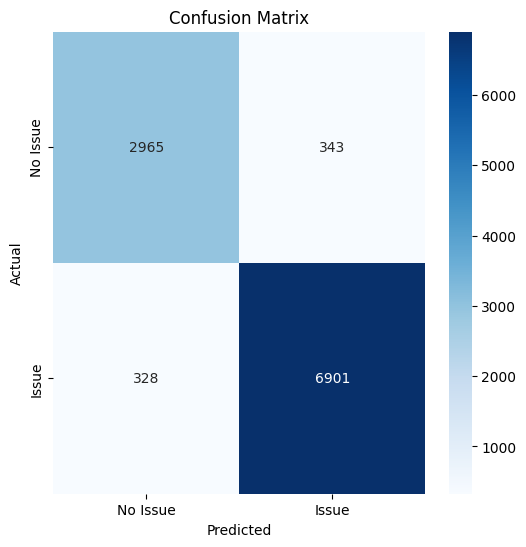

AUC Score: 0.9802
95% CI for AUC: [0.9779, 0.9825]


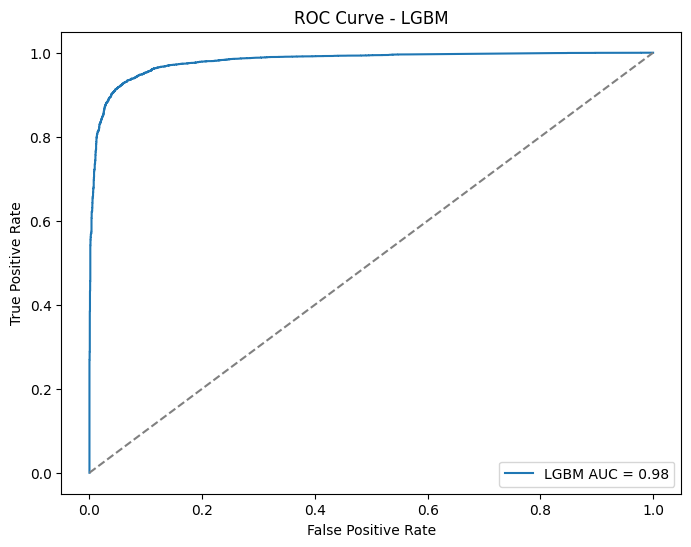

In [ ]:
evaluate_model(LGBM, X_test_1, y_test_1, model_name="LGBM", use_proba=True)

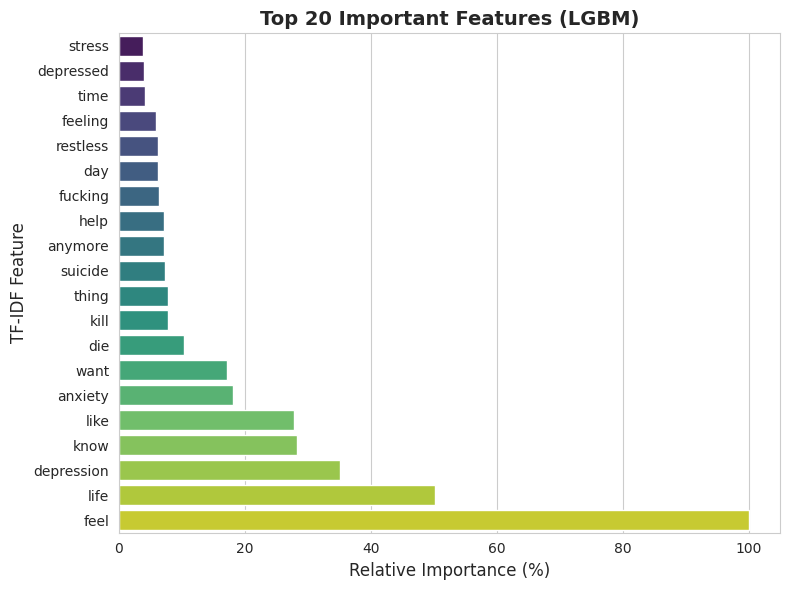

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if LGBM is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = LGBM.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (LGBM)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_lgbm.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


## 3.2  DL Models


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from collections import Counter
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Compare performance with Stats Test


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import accuracy_score
import numpy as np

def run_mcnemar_test(y_true, y_pred_1, y_pred_2, model_1_name="Model 1", model_2_name="Model 2"):
    assert len(y_true) == len(y_pred_1) == len(y_pred_2), "Length mismatch."

    # Create contingency table
    both_correct = np.sum((y_pred_1 == y_true) & (y_pred_2 == y_true))
    model1_correct = np.sum((y_pred_1 == y_true) & (y_pred_2 != y_true))
    model2_correct = np.sum((y_pred_1 != y_true) & (y_pred_2 == y_true))
    both_wrong = np.sum((y_pred_1 != y_true) & (y_pred_2 != y_true))

    table = [[both_correct, model2_correct],
             [model1_correct, both_wrong]]

    result = mcnemar(table, exact=False, correction=True)
    print(f"\n--- McNemar’s Test: {model_1_name} vs {model_2_name} ---")
    print(f"Statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")
    if result.pvalue < 0.05:
        print("=> Significant difference.")
    else:
        print("=> No significant difference.")
SVM_preds = SVM.predict(X_test_1)
LGBM_preds = LGBM.predict(X_test_1)
run_mcnemar_test(y_test_1, SVM_preds, LGBM_preds, "SVM", "LGBM")





--- McNemar’s Test: SVM vs LGBM ---
Statistic = 6.7522, p-value = 0.0094
=> Significant difference.


In [ ]:
RandomForest_preds = RandomForest.predict(X_test_1)
LR_preds = LR.predict(X_test_1)

### 3.2.1 ALBERT

In [ ]:
#make a copy especially for ALBERT
df2 = df.copy()

In [ ]:
# Pre-processing for ALBERT
def clean_text_Albert(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "<URL>", text)  # Replace URLs with <URL>
    text = re.sub(r"@\w+", "<USER>", text)   # Replace mentions with <USER>
    text = re.sub(r"#\w+", "<HASHTAG>", text)  # Replace hashtags with <HASHTAG>
    text = re.sub(r"[^\w\s]", "", text)      # Remove special characters
    text = re.sub(r"\s+", " ", text)         # Normalize whitespace
    return text.strip()

df2['statement'] = df2['statement'].apply(clean_text_Albert)

Pre-processing is minimal for ALBERT,

Not Required:

Stopword Removal:\
ALBERT learns word importance from context, so stopwords (e.g., "the", "is") should remain.

Lemmatization:\
Transformer models like ALBERT are context-aware and already handle semantic relationships between words like "running", "ran", and "run". Lemmatization or stemming can be skipped.



Punctuation Removal:\
Do not remove punctuation, as it can change the meaning of sentences (e.g., "I’m fine." vs. "I’m fine!"). But when we use traditional model with TF-IDF, removing punctuation helps reduce noises.\

Tokenization:\
ALBERT's tokenizer handles tokenization internally, splitting text into subword units (WordPiece tokens).


In [ ]:
# Initial train-test split: 60% train, 20% test, 20% validation
train_texts_2, test_texts_2, train_labels_2, test_labels_2 = train_test_split(
    df2['statement'].tolist(), df2['status'].tolist(), test_size=0.2, random_state=42
)
train_texts_2, val_texts_2, train_labels_2, val_labels_2 = train_test_split(
    train_texts_2, train_labels_2, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of original data
)


#Prepare the data for the model
# Load tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
max_len = 200

# Create Dataset objects
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)  # Ensure texts is a list of strings
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure each text is a string
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset_2 = SentimentDataset(train_texts_2, train_labels_2, tokenizer,max_len)
test_dataset_2 = SentimentDataset(test_texts_2, test_labels_2, tokenizer,max_len)
val_dataset_2 = SentimentDataset(val_texts_2,val_labels_2,tokenizer,max_len)


# Create DataLoaders
train_loader_2 = DataLoader(train_dataset_2, batch_size=4, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2,batch_size = 4)
test_loader_2 = DataLoader(test_dataset_2, batch_size=4)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
random.seed(1234)

def random_hyperparameter_tuning(train_texts, train_labels, val_texts, val_labels, tokenizer, n_iter=10):
    # Define hyperparameter ranges
    param_space = {
        'lr': (np.log10(1e-5), np.log10(1e-4)),              # Learning rate range
        'epochs': (3, 5),                # Epoch range
        'dropout': (0.1, 0.5)           # Dropout rate range
    }

    best_f1 = 0
    best_params = None
    best_model = None

    # Compute class weights for class imbalance
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Progress bar for random search iterations
    with tqdm(total=n_iter, desc="Random Search Tuning", leave=True) as pbar:
        for _ in range(n_iter):
            # Randomly sample hyperparameters
            hyperparams = {
                'lr': 10**np.random.uniform(*param_space['lr']),
                'epochs': np.random.randint(*param_space['epochs']),
                'dropout': np.random.uniform(*param_space['dropout'])
            }

            # Initialize model with dropout
            model = AlbertForSequenceClassification.from_pretrained(
                'albert-base-v2',
                num_labels=2,
                hidden_dropout_prob=hyperparams['dropout']
            ).to(device)

            optimizer = AdamW(model.parameters(), lr=hyperparams['lr'])
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

            # Training loop
            for epoch in range(hyperparams['epochs']):
                model.train()
                for batch in train_loader_2:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()

            # Validation evaluation
            model.eval()
            val_predictions, val_labels_batch = [], []
            with torch.no_grad():
                for batch in val_loader_2:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask)
                    preds = torch.argmax(outputs.logits, dim=1)
                    val_predictions.extend(preds.cpu().numpy())
                    val_labels_batch.extend(labels.cpu().numpy())

            # Calculate F1-score
            f1 = f1_score(val_labels_batch, val_predictions, average='weighted')
            accuracy = accuracy_score(val_labels_batch, val_predictions)

            # Update best model
            if f1 > best_f1:
                best_f1 = f1
                best_params = hyperparams
                best_model = model
                # Save the best model
                model_save_path = "best_albert_model.pth"
                torch.save(model.state_dict(), model_save_path)

            # Update progress bar
            pbar.set_postfix(f1=f1, accuracy=accuracy)
            pbar.update(1)

    print(f"Best F1 Score: {best_f1:.4f}")
    print(f"Best Hyperparameters: {best_params}")
    return best_params, best_f1, best_model

#Start timer
start_time = time.time()
best_params, best_f1, best_model = random_hyperparameter_tuning(
    train_texts=train_texts_2,
    train_labels=train_labels_2,
    val_texts=val_texts_2,
    val_labels=val_labels_2,
    tokenizer=tokenizer,
    n_iter=10
)
# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer with the same config as during training
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
model.load_state_dict(torch.load("best_albert_binary_model.pth", map_location=device))
model.to(device)

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Evaluation
model.eval()
test_predictions_albert, test_labels_batch_albert, test_probabilities_albert = [], [], []

with torch.no_grad():
    for batch in test_loader_2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        test_predictions_albert.extend(preds.cpu().numpy())
        test_labels_batch_albert.extend(labels.cpu().numpy())
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        test_probabilities_albert.extend(probs.cpu().numpy())

# Metrics
test_f1 = f1_score(test_labels_batch_albert, test_predictions_albert, average='weighted')
test_accuracy = accuracy_score(test_labels_batch_albert, test_predictions_albert)

print(f"Test F-1 Score: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test F-1 Score: 0.9650, Test Accuracy: 0.9650


In [ ]:
def evaluate_pytorch_model(model, test_loader, device, model_name="DL Model", num_classes=2, use_attention_mask=True):
    model.eval()
    model.to(device)

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            # Transformer: with attention mask
            if use_attention_mask:
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
            else:
                outputs = model(input_ids)

            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    if num_classes == 2:
        positive_probs = all_probs[:, 1]
    else:
        positive_probs = None

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n--- Evaluation Report: {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # F1 CI
    f1_scores = []
    for _ in range(1000):
        idx = resample(np.arange(len(all_labels)))
        if len(np.unique(all_labels[idx])) < 2:
            continue
        f1_bs = f1_score(all_labels[idx], all_preds[idx], average='weighted')
        f1_scores.append(f1_bs)
    print(f"95% CI for F1 Score: [{np.percentile(f1_scores, 2.5):.4f}, {np.percentile(f1_scores, 97.5):.4f}]")

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC
    if num_classes == 2:
        fpr, tpr, _ = roc_curve(all_labels, positive_probs)
        roc_auc = auc(fpr, tpr)

        auc_scores = []
        for _ in range(1000):
            idx = resample(np.arange(len(all_labels)))
            if len(np.unique(all_labels[idx])) < 2:
                continue
            fpr_bs, tpr_bs, _ = roc_curve(all_labels[idx], positive_probs[idx])
            auc_scores.append(auc(fpr_bs, tpr_bs))
        print(f"AUC: {roc_auc:.4f}")
        print(f"95% CI for AUC: [{np.percentile(auc_scores, 2.5):.4f}, {np.percentile(auc_scores, 97.5):.4f}]")

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc='lower right')
        plt.show()


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluation Report: ALBERT ---
Accuracy: 0.9650
Weighted F1 Score: 0.9650
95% CI for F1 Score: [0.9613, 0.9685]


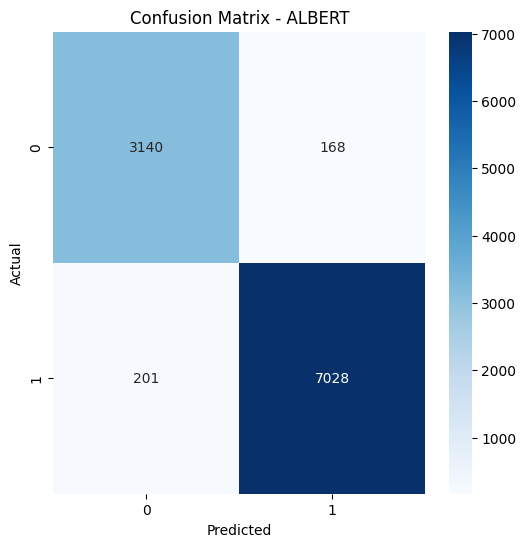

AUC: 0.9928
95% CI for AUC: [0.9916, 0.9941]


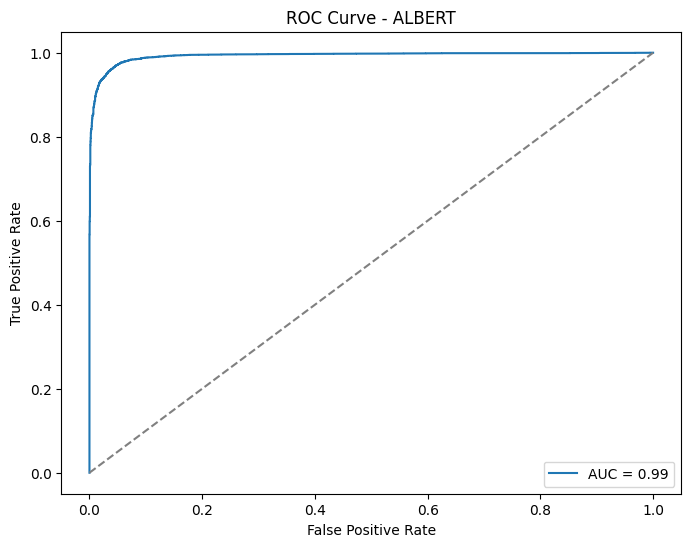

In [ ]:
albert = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
albert.load_state_dict(torch.load("best_albert_binary_model.pth", map_location=device))
albert.to(device)
evaluate_pytorch_model(albert, test_loader_2, device, model_name="ALBERT", num_classes=2, use_attention_mask=True)


In [ ]:
best_model = model
best_model.to(device)

# Initialize lists to store predictions and labels
test_predictions, test_labels_batch, test_probabilities = [], [], []

# Set the model to evaluation mode
best_model.eval()

# Perform evaluation
with torch.no_grad():
    for batch in test_loader_2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = best_model(input_ids, attention_mask=attention_mask)

        # Predicted labels
        preds = torch.argmax(outputs.logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())

        # True labels
        test_labels_batch.extend(labels.cpu().numpy())

        # Probabilities for class 1
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        test_probabilities.extend(probs.cpu().numpy())

# Calculate F1 Score and Accuracy
test_f1 = f1_score(test_labels_batch, test_predictions, average='weighted')
test_accuracy = accuracy_score(test_labels_batch, test_predictions)

print(f"Test F-1 Score: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test F-1 Score: 0.9566, Test Accuracy: 0.9565


### 3.2.2 GRU

In [ ]:
#copy for GRU
df3 = df.copy()

In [ ]:
# Pre-processing for GRU - still minimal
def clean_text_GRU(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "<URL>", text)  # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)   # Replace mentions
    text = re.sub(r"#\w+", "<HASHTAG>", text)  # Replace hashtags
    text = re.sub(r"[^\w\s]", "", text)      # Remove special characters
    text = re.sub(r"\s+", " ", text)         # Normalize whitespace
    return text.strip()

df3['statement'] = df3['statement'].apply(clean_text_GRU)

In [ ]:
# Hyperparameters
from collections import Counter
MAX_LEN = 200  # Maximum sequence length
VOCAB_SIZE = 10000  # Vocabulary size
BATCH_SIZE = 16

# Split Dataset
# Initial train-test split
train_texts_3, test_texts_3, train_labels_3, test_labels_3 = train_test_split(
    df3['statement'].tolist(), df3['status'].tolist(), test_size=0.2, random_state=42
)
# Further split training data into training and validation sets
train_texts_3, val_texts_3, train_labels_3, val_labels_3 = train_test_split(
    train_texts_3, train_labels_3, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of original data
)

# **MODIFIED**: Build Vocabulary after the train-validation-test split
# Build Vocabulary on Training Data Only
all_train_words = " ".join(train_texts_3).split()
most_common_words = [word for word, _ in Counter(all_train_words).most_common(VOCAB_SIZE - 1)]
word_to_index = {word: idx + 1 for idx, word in enumerate(most_common_words)}

# Text-to-Sequence Conversion
def text_to_sequence(text, word_to_index, max_len=MAX_LEN):
    tokens = text.split()
    sequence = [word_to_index.get(word, 0) for word in tokens]
    return sequence[:max_len]

# Convert text to sequences for train, validation, and test sets
train_sequences_3 = [text_to_sequence(text, word_to_index) for text in train_texts_3]
val_sequences_3 = [text_to_sequence(text, word_to_index) for text in val_texts_3]
test_sequences_3 = [text_to_sequence(text, word_to_index) for text in test_texts_3]

# Pad Sequences
train_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in train_sequences_3], batch_first=True, padding_value=0)
val_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in val_sequences_3], batch_first=True, padding_value=0)
test_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in test_sequences_3], batch_first=True, padding_value=0)

# Convert Labels
train_labels_3 = torch.tensor(train_labels_3, dtype=torch.long)
val_labels_3 = torch.tensor(val_labels_3, dtype=torch.long)
test_labels_3 = torch.tensor(test_labels_3, dtype=torch.long)

# Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.texts[idx],
            'label': self.labels[idx]
        }

# Create Datasets and DataLoaders
train_dataset_3 = SentimentDataset(train_sequences_3, train_labels_3)
val_dataset_3 = SentimentDataset(val_sequences_3, val_labels_3)
test_dataset_3 = SentimentDataset(test_sequences_3, test_labels_3)

train_loader_3 = DataLoader(train_dataset_3, batch_size=BATCH_SIZE, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=BATCH_SIZE)
test_loader_3 = DataLoader(test_dataset_3, batch_size=BATCH_SIZE)

In [ ]:
# Define GRU Model
class GRUSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUSentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, hidden = self.gru(embedded)  # Only last hidden state
        output = self.fc(self.dropout(hidden[-1]))
        return output  # **MODIFIED**: Removed `softmax` because `CrossEntropyLoss` expects raw logits

# #Define Loss Function
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.2, gamma=0.5, ignore_index=-1):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.ignore_index = ignore_index
#         self.cross_entropy = nn.CrossEntropyLoss(ignore_index=ignore_index, reduction='none')

#     def forward(self, logits, target):
#         # Cross entropy loss
#         ce_loss = self.cross_entropy(logits, target)
#         # Probabilities of correct class
#         pt = torch.exp(-ce_loss)
#         # Focal loss
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()



In [ ]:
random.seed(1234)

def train_and_evaluate(hyperparams, train_loader, val_loader, vocab_size, output_dim, device):
    embedding_dim = int(hyperparams['embedding_dim'])
    hidden_dim = int(hyperparams['hidden_dim'])
    lr = hyperparams['lr']
    # alpha = hyperparams['alpha']
    # gamma = hyperparams['gamma']

    # Initialize the model, loss, and optimizer
    model = GRUSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

    # **MODIFIED**: Compute class weights for the training set
    all_train_labels = [label for batch in train_loader for label in batch['label'].numpy()]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(all_train_labels),
        y=all_train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert to PyTorch tensor

    # **MODIFIED**: Use CrossEntropyLoss with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(hyperparams['epochs']):
        model.train()
        total_loss = 0
        train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{hyperparams['epochs']}", leave=True, position=0)
        for batch in train_loop:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)  # **MODIFIED**: Use CrossEntropyLoss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            train_loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}/{hyperparams['epochs']}, Loss: {total_loss / len(train_loader):.4f}")

    # Validation evaluation
    model.eval()
    val_predictions, val_labels = [], []
    val_loop = tqdm(val_loader, desc="Validating", leave=True, position=0)
    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate F1 score and accuracy
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    accuracy = accuracy_score(val_labels, val_predictions)
    print(f"Validation F-1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return f1, accuracy, model


def random_hyperparameter_tuning(train_loader, val_loader, vocab_size, output_dim, device, n_iter=20):
    # Define hyperparameter ranges for random search
    param_space = {
        'embedding_dim': (150, 250),
        'hidden_dim': (256, 768),
        'lr': (np.log10(1e-4), np.log10(1e-3)),  # Log-uniform for learning rate
        'epochs': (5, 10),  # **MODIFIED**: Removed `alpha` and `gamma` since FocalLoss is no longer used
    }

    best_f1 = 0
    best_params = None
    best_model = None

    # Random search iterations
    with tqdm(total=n_iter, desc="Random Search Tuning", leave=True, position=0) as pbar:
        for _ in range(n_iter):
            # Sample hyperparameters
            hyperparams = {
                'embedding_dim': np.random.uniform(*param_space['embedding_dim']),
                'hidden_dim': np.random.uniform(*param_space['hidden_dim']),
                'lr': 10**np.random.uniform(*param_space['lr']),
                'epochs': np.random.randint(*param_space['epochs']),
            }
            f1, accuracy, model = train_and_evaluate(hyperparams, train_loader, val_loader, vocab_size, output_dim, device)
            pbar.set_postfix(f1=f1, accuracy=accuracy)
            pbar.update(1)

            if f1 > best_f1:
                best_f1 = f1
                best_params = hyperparams
                best_model = model

    print(f"Best Validation F1 Score: {best_f1:.4f}")
    print(f"Best Hyperparameters: {best_params}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_gru_model.pth")
    return best_params, best_f1, best_model

#Start timer
start_time = time.time()
# Run random search
best_params, best_f1, best_model= random_hyperparameter_tuning(
    train_loader_3,
    val_loader_3,
    vocab_size=VOCAB_SIZE,
    output_dim=2,
    device=device,
    n_iter=10  # Number of random samples to evaluate
)
# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:20<00:00, 96.64it/s, loss=0.0548]


Epoch 1/9, Loss: 0.2157


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.16it/s, loss=0.00313]


Epoch 2/9, Loss: 0.1209


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:19<00:00, 99.98it/s, loss=0.316] 


Epoch 3/9, Loss: 0.0834


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.60it/s, loss=0.0182]


Epoch 4/9, Loss: 0.0466


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.15it/s, loss=0.00192]


Epoch 5/9, Loss: 0.0315


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:20<00:00, 98.35it/s, loss=0.00143]


Epoch 6/9, Loss: 0.0234


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:19<00:00, 99.80it/s, loss=0.000907]


Epoch 7/9, Loss: 0.0202


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.34it/s, loss=0.00811]


Epoch 8/9, Loss: 0.0177


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:19<00:00, 99.83it/s, loss=0.00387] 


Epoch 9/9, Loss: 0.0159


Random Search Tuning:  10%|█         | 1/10 [03:01<27:14, 181.60s/it, accuracy=0.946, f1=0.946]

Validation F-1 Score: 0.9463, Accuracy: 0.9465


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:18<00:00, 106.41it/s, loss=0.0602]


Epoch 1/9, Loss: 0.2082


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:18<00:00, 106.12it/s, loss=0.00623]


Epoch 2/9, Loss: 0.1173


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:18<00:00, 105.57it/s, loss=0.00605]


Epoch 3/9, Loss: 0.0709


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:18<00:00, 106.67it/s, loss=0.00194]


Epoch 4/9, Loss: 0.0407


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:18<00:00, 106.55it/s, loss=0.000582]


Epoch 5/9, Loss: 0.0229


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:18<00:00, 106.70it/s, loss=0.00258]


Epoch 6/9, Loss: 0.0166


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:18<00:00, 105.88it/s, loss=0.000325]


Epoch 7/9, Loss: 0.0153


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:18<00:00, 106.26it/s, loss=0.00976]


Epoch 8/9, Loss: 0.0150


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:18<00:00, 105.40it/s, loss=0.000112]


Epoch 9/9, Loss: 0.0122


Random Search Tuning:  20%|██        | 2/10 [05:51<23:17, 174.67s/it, accuracy=0.948, f1=0.948]

Validation F-1 Score: 0.9481, Accuracy: 0.9479


Training Epoch 1/6: 100%|██████████| 1976/1976 [00:19<00:00, 99.02it/s, loss=0.429]


Epoch 1/6, Loss: 0.3182


Training Epoch 2/6: 100%|██████████| 1976/1976 [00:19<00:00, 99.14it/s, loss=0.0129]


Epoch 2/6, Loss: 0.1789


Training Epoch 3/6: 100%|██████████| 1976/1976 [00:19<00:00, 98.97it/s, loss=0.00602]


Epoch 3/6, Loss: 0.1458


Training Epoch 4/6: 100%|██████████| 1976/1976 [00:19<00:00, 98.88it/s, loss=0.104]


Epoch 4/6, Loss: 0.1214


Training Epoch 5/6: 100%|██████████| 1976/1976 [00:19<00:00, 98.97it/s, loss=0.00499]


Epoch 5/6, Loss: 0.1023


Training Epoch 6/6: 100%|██████████| 1976/1976 [00:19<00:00, 98.83it/s, loss=1.13]


Epoch 6/6, Loss: 0.0850


Random Search Tuning:  30%|███       | 3/10 [07:54<17:36, 150.92s/it, accuracy=0.942, f1=0.943]

Validation F-1 Score: 0.9426, Accuracy: 0.9420


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:22<00:00, 85.97it/s, loss=0.156]


Epoch 1/9, Loss: 0.2625


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:23<00:00, 85.60it/s, loss=0.172]


Epoch 2/9, Loss: 0.1475


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:23<00:00, 85.83it/s, loss=0.0138]


Epoch 3/9, Loss: 0.1105


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:23<00:00, 85.80it/s, loss=0.0227]


Epoch 4/9, Loss: 0.0807


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:22<00:00, 86.04it/s, loss=0.24]


Epoch 5/9, Loss: 0.0550


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:22<00:00, 86.21it/s, loss=0.0108]


Epoch 6/9, Loss: 0.0361


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:22<00:00, 85.97it/s, loss=0.00159]


Epoch 7/9, Loss: 0.0251


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:23<00:00, 85.90it/s, loss=0.00135]


Epoch 8/9, Loss: 0.0177


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:22<00:00, 86.15it/s, loss=0.00822]


Epoch 9/9, Loss: 0.0147


Random Search Tuning:  40%|████      | 4/10 [11:23<17:25, 174.19s/it, accuracy=0.947, f1=0.947]

Validation F-1 Score: 0.9473, Accuracy: 0.9474


Training Epoch 1/7: 100%|██████████| 1976/1976 [00:23<00:00, 82.91it/s, loss=0.0109]


Epoch 1/7, Loss: 0.2375


Training Epoch 2/7: 100%|██████████| 1976/1976 [00:23<00:00, 83.00it/s, loss=0.0886]


Epoch 2/7, Loss: 0.1388


Training Epoch 3/7: 100%|██████████| 1976/1976 [00:23<00:00, 83.05it/s, loss=0.09]


Epoch 3/7, Loss: 0.1035


Training Epoch 4/7: 100%|██████████| 1976/1976 [00:23<00:00, 83.02it/s, loss=0.0096]


Epoch 4/7, Loss: 0.0760


Training Epoch 5/7: 100%|██████████| 1976/1976 [00:23<00:00, 83.06it/s, loss=0.000893]


Epoch 5/7, Loss: 0.0481


Training Epoch 6/7: 100%|██████████| 1976/1976 [00:23<00:00, 83.08it/s, loss=0.0094]


Epoch 6/7, Loss: 0.0299


Training Epoch 7/7: 100%|██████████| 1976/1976 [00:23<00:00, 83.04it/s, loss=0.000632]


Epoch 7/7, Loss: 0.0235


Random Search Tuning:  50%|█████     | 5/10 [14:13<14:23, 172.65s/it, accuracy=0.949, f1=0.949]

Validation F-1 Score: 0.9487, Accuracy: 0.9487


Training Epoch 1/7: 100%|██████████| 1976/1976 [00:18<00:00, 106.18it/s, loss=0.0488]


Epoch 1/7, Loss: 0.3056


Training Epoch 2/7: 100%|██████████| 1976/1976 [00:18<00:00, 106.91it/s, loss=0.0513]


Epoch 2/7, Loss: 0.1646


Training Epoch 3/7: 100%|██████████| 1976/1976 [00:18<00:00, 106.09it/s, loss=0.0183]


Epoch 3/7, Loss: 0.1362


Training Epoch 4/7: 100%|██████████| 1976/1976 [00:18<00:00, 105.78it/s, loss=0.339]


Epoch 4/7, Loss: 0.1122


Training Epoch 5/7: 100%|██████████| 1976/1976 [00:18<00:00, 105.24it/s, loss=0.0203]


Epoch 5/7, Loss: 0.0922


Training Epoch 6/7: 100%|██████████| 1976/1976 [00:18<00:00, 104.76it/s, loss=0.00806]


Epoch 6/7, Loss: 0.0735


Training Epoch 7/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.62it/s, loss=0.0145]


Epoch 7/7, Loss: 0.0591


Random Search Tuning:  60%|██████    | 6/10 [16:27<10:37, 159.31s/it, accuracy=0.944, f1=0.944]

Validation F-1 Score: 0.9442, Accuracy: 0.9437


Training Epoch 1/5: 100%|██████████| 1976/1976 [00:19<00:00, 99.06it/s, loss=0.0783]


Epoch 1/5, Loss: 0.2392


Training Epoch 2/5: 100%|██████████| 1976/1976 [00:19<00:00, 99.37it/s, loss=0.0875] 


Epoch 2/5, Loss: 0.1310


Training Epoch 3/5: 100%|██████████| 1976/1976 [00:20<00:00, 98.68it/s, loss=0.131] 


Epoch 3/5, Loss: 0.0954


Training Epoch 4/5: 100%|██████████| 1976/1976 [00:19<00:00, 99.27it/s, loss=0.013] 


Epoch 4/5, Loss: 0.0660


Training Epoch 5/5: 100%|██████████| 1976/1976 [00:19<00:00, 99.11it/s, loss=0.000929] 


Epoch 5/5, Loss: 0.0418


Random Search Tuning:  70%|███████   | 7/10 [18:09<07:02, 140.70s/it, accuracy=0.945, f1=0.945]

Validation F-1 Score: 0.9453, Accuracy: 0.9448


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:19<00:00, 99.29it/s, loss=0.431]


Epoch 1/9, Loss: 0.2744


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.81it/s, loss=0.0158]


Epoch 2/9, Loss: 0.1550


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.28it/s, loss=0.274]


Epoch 3/9, Loss: 0.1244


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:19<00:00, 101.00it/s, loss=0.011]


Epoch 4/9, Loss: 0.0996


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.30it/s, loss=0.029]


Epoch 5/9, Loss: 0.0736


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.51it/s, loss=0.056]


Epoch 6/9, Loss: 0.0535


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.83it/s, loss=0.00186]


Epoch 7/9, Loss: 0.0369


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.48it/s, loss=0.00124]


Epoch 8/9, Loss: 0.0276


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:19<00:00, 100.30it/s, loss=0.00194]


Epoch 9/9, Loss: 0.0220


Random Search Tuning:  80%|████████  | 8/10 [21:09<05:06, 153.15s/it, accuracy=0.946, f1=0.946]

Validation F-1 Score: 0.9460, Accuracy: 0.9457


Training Epoch 1/5: 100%|██████████| 1976/1976 [00:19<00:00, 100.68it/s, loss=0.0894]


Epoch 1/5, Loss: 0.2432


Training Epoch 2/5: 100%|██████████| 1976/1976 [00:19<00:00, 100.38it/s, loss=0.0832]


Epoch 2/5, Loss: 0.1366


Training Epoch 3/5: 100%|██████████| 1976/1976 [00:19<00:00, 100.74it/s, loss=0.00596]


Epoch 3/5, Loss: 0.1008


Training Epoch 4/5: 100%|██████████| 1976/1976 [00:19<00:00, 100.98it/s, loss=0.0117]


Epoch 4/5, Loss: 0.0665


Training Epoch 5/5: 100%|██████████| 1976/1976 [00:19<00:00, 100.84it/s, loss=0.1]


Epoch 5/5, Loss: 0.0421


Random Search Tuning:  90%|█████████ | 9/10 [22:50<02:16, 136.76s/it, accuracy=0.952, f1=0.952]

Validation F-1 Score: 0.9523, Accuracy: 0.9523


Training Epoch 1/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.69it/s, loss=0.196] 


Epoch 1/8, Loss: 0.2153


Training Epoch 2/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.48it/s, loss=0.0346]


Epoch 2/8, Loss: 0.1183


Training Epoch 3/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.95it/s, loss=0.466]


Epoch 3/8, Loss: 0.0749


Training Epoch 4/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.22it/s, loss=6.57e-5]


Epoch 4/8, Loss: 0.0383


Training Epoch 5/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.28it/s, loss=0.00213]


Epoch 5/8, Loss: 0.0237


Training Epoch 6/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.47it/s, loss=0.000424]


Epoch 6/8, Loss: 0.0178


Training Epoch 7/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.04it/s, loss=7.83e-6]


Epoch 7/8, Loss: 0.0142


Training Epoch 8/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.06it/s, loss=0.000331]


Epoch 8/8, Loss: 0.0133


Random Search Tuning: 100%|██████████| 10/10 [25:30<00:00, 153.07s/it, accuracy=0.947, f1=0.947]

Validation F-1 Score: 0.9465, Accuracy: 0.9467
Best Validation F1 Score: 0.9523
Best Hyperparameters: {'embedding_dim': 156.02979350260784, 'hidden_dim': 467.03628008471236, 'lr': 0.000411395570516993, 'epochs': 5}
Total Parameter Tuning Time: 1530.76 seconds


In [ ]:
hyperparams = {'embedding_dim': 156.02979350260784, 'hidden_dim': 467.03628008471236, 'lr': 0.000411395570516993, 'epochs': 5}
train_loader = train_loader_3
val_loader=val_loader_3
vocab_size=VOCAB_SIZE
output_dim=2
device=device
embedding_dim = int(hyperparams['embedding_dim'])
hidden_dim = int(hyperparams['hidden_dim'])
lr = hyperparams['lr']
# alpha = hyperparams['alpha']
# gamma = hyperparams['gamma']

# Initialize the model, loss, and optimizer
model = GRUSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

# **MODIFIED**: Compute class weights for the training set
all_train_labels = [label for batch in train_loader for label in batch['label'].numpy()]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_train_labels),
    y=all_train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert to PyTorch tensor

# **MODIFIED**: Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(hyperparams['epochs']):
    model.train()
    total_loss = 0
    train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{hyperparams['epochs']}", leave=True, position=0)
    for batch in train_loop:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)  # **MODIFIED**: Use CrossEntropyLoss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1}/{hyperparams['epochs']}, Loss: {total_loss / len(train_loader):.4f}")

Training Epoch 1/5: 100%|██████████| 1976/1976 [00:33<00:00, 59.46it/s, loss=0.0445]


Epoch 1/5, Loss: 0.2493


Training Epoch 2/5: 100%|██████████| 1976/1976 [00:33<00:00, 58.14it/s, loss=0.0143]


Epoch 2/5, Loss: 0.1423


Training Epoch 3/5: 100%|██████████| 1976/1976 [00:35<00:00, 54.99it/s, loss=0.194]


Epoch 3/5, Loss: 0.1061


Training Epoch 4/5: 100%|██████████| 1976/1976 [00:34<00:00, 56.86it/s, loss=0.0048]


Epoch 4/5, Loss: 0.0758


Training Epoch 5/5: 100%|██████████| 1976/1976 [00:36<00:00, 54.72it/s, loss=0.00537]

Epoch 5/5, Loss: 0.0491


In [ ]:
model_save_path = "GRU_Binary.pth"
torch.save(model.state_dict(), model_save_path)

In [ ]:
# Evaluate the best model on the test set
best_model = model
best_model.eval()
test_predictions, test_labels = [], []

# **MODIFIED**: Added probabilities collection for further analysis if needed
test_probabilities = []
test_loop = tqdm(test_loader_3, desc="Testing Best Model", leave=True, position=0)
with torch.no_grad():
    for batch in test_loop:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = best_model(input_ids)

        # **MODIFIED**: Added probability calculation using softmax
        probs = torch.softmax(outputs, dim=1)  # Probabilities for each class
        preds = torch.argmax(probs, dim=1)  # Predicted class

        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        # **MODIFIED**: Collect probabilities of the positive class (e.g., class 1)
        test_probabilities.extend(probs[:, 1].cpu().numpy())

# Calculate F1 score and accuracy on the test set
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Test F-1 Score: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, digits=4))

Testing Best Model: 100%|██████████| 659/659 [00:06<00:00, 105.99it/s]


Test F-1 Score: 0.9520, Test Accuracy: 0.9522

Classification Report:
              precision    recall  f1-score   support

           0     0.9333    0.9129    0.9230      3308
           1     0.9606    0.9701    0.9653      7229

    accuracy                         0.9522     10537
   macro avg     0.9469    0.9415    0.9441     10537
weighted avg     0.9520    0.9522    0.9520     10537




--- Evaluation Report: gru ---
Accuracy: 0.9522
Weighted F1 Score: 0.9520
95% CI for F1 Score: [0.9478, 0.9558]


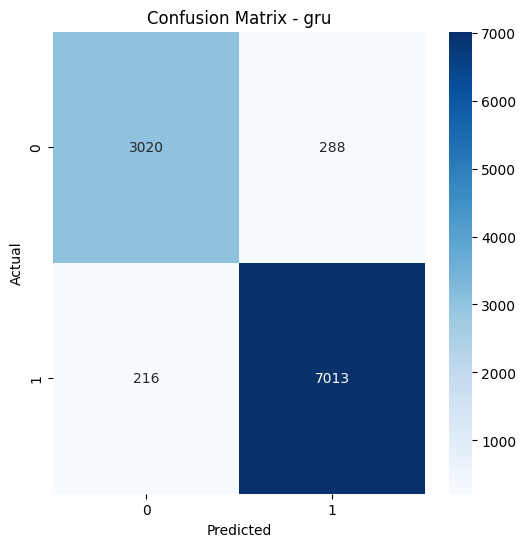

AUC: 0.9879
95% CI for AUC: [0.9863, 0.9896]


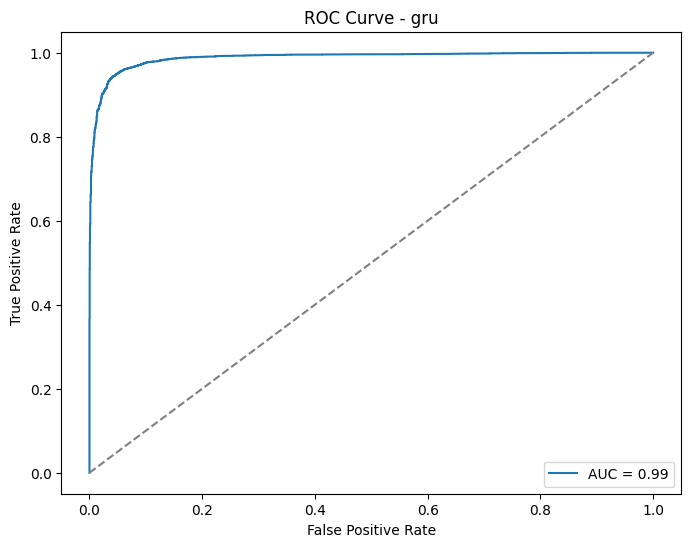

In [ ]:
gru =  GRUSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
gru.load_state_dict(torch.load("GRU_Binary.pth", map_location=device))
gru.to(device)
evaluate_pytorch_model(gru, test_loader_3, device, model_name="gru", num_classes=2, use_attention_mask=False)


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
from itertools import combinations

def run_mcnemar_test(y_true, model_preds, method='holm'):
    """
    Perform pairwise McNemar's test for all model combinations.

    Parameters:
        y_true (np.ndarray): True labels
        model_preds (dict): Dictionary with model names as keys and model predictions as values
        method (str): p-value correction method (e.g., 'holm', 'bonferroni')

    Returns:
        pd.DataFrame: Results table
    """
    assert all(len(y_true) == len(preds) for preds in model_preds.values()), "All predictions must match y_true length."

    results = []
    model_names = list(model_preds.keys())

    # Run pairwise McNemar tests
    for m1, m2 in combinations(model_names, 2):
        y_pred_1, y_pred_2 = model_preds[m1], model_preds[m2]

        # Create contingency table
        both_correct = np.sum((y_pred_1 == y_true) & (y_pred_2 == y_true))
        model1_correct = np.sum((y_pred_1 == y_true) & (y_pred_2 != y_true))
        model2_correct = np.sum((y_pred_1 != y_true) & (y_pred_2 == y_true))
        both_wrong = np.sum((y_pred_1 != y_true) & (y_pred_2 != y_true))

        table = [[both_correct, model2_correct],
                 [model1_correct, both_wrong]]

        result = mcnemar(table, exact=False, correction=True)

        # Store results
        results.append({
            "Model 1": m1,
            "Model 2": m2,
            "Statistic": result.statistic,
            "p-value": result.pvalue,
            "Winner": m1 if model1_correct > model2_correct else (m2 if model2_correct > model1_correct else "Tie")
        })

    # Correct for multiple testing
    raw_pvals = [r["p-value"] for r in results]
    from statsmodels.stats.multitest import multipletests
    _, corrected_pvals, _, _ = multipletests(raw_pvals, method=method)

    for i, p_corr in enumerate(corrected_pvals):
        results[i]["Corrected p-value"] = p_corr
        results[i]["Significant"] = "Yes" if p_corr < 0.05 else "No"

    # Print results
    import pandas as pd
    df_results = pd.DataFrame(results)
    print("\n📊 Pairwise McNemar's Test Results (corrected using '{}'):\n".format(method))
    print(df_results[["Model 1", "Model 2", "Winner", "Statistic", "Corrected p-value", "Significant"]])

    return df_results
  # Assume you have predictions from multiple models
model_preds = {
    "SVM": SVM_preds,
    "LGBM": LGBM_preds,
    "RandomForest": RandomForest_preds,
    "LR":LR_preds,
   "ALBERT": np.array(test_predictions_albert),
   "GRU": np.array(test_predictions),
}

# y_test_1 is the ground truth
run_mcnemar_test(y_test_1, model_preds)




📊 Pairwise McNemar's Test Results (corrected using 'holm'):

         Model 1       Model 2  Winner   Statistic  Corrected p-value  \
0            SVM          LGBM     SVM    6.752232       3.745219e-02   
1            SVM  RandomForest     SVM    9.734737       9.040895e-03   
2            SVM            LR     SVM   13.267544       1.620245e-03   
3            SVM        ALBERT  ALBERT  107.571685       4.003413e-24   
4            SVM           GRU     GRU   21.043478       3.142849e-05   
5           LGBM  RandomForest    LGBM    0.437690       1.000000e+00   
6           LGBM            LR     Tie    0.001992       1.000000e+00   
7           LGBM        ALBERT  ALBERT  159.508803       2.173008e-35   
8           LGBM           GRU     GRU   49.650450       1.837279e-11   
9   RandomForest            LR      LR    0.264220       1.000000e+00   
10  RandomForest        ALBERT  ALBERT  158.769726       2.941594e-35   
11  RandomForest           GRU     GRU   54.864726       1.420

,Model 1,Model 2,Statistic,p-value,Winner,Corrected p-value,Significant
0,SVM,LGBM,6.752232,9.363048e-03,SVM,3.745219e-02,Yes
1,SVM,RandomForest,9.734737,1.808179e-03,SVM,9.040895e-03,Yes
2,SVM,LR,13.267544,2.700408e-04,SVM,1.620245e-03,Yes
3,SVM,ALBERT,107.571685,3.336177e-25,ALBERT,4.003413e-24,Yes
4,SVM,GRU,21.043478,4.489784e-06,GRU,3.142849e-05,Yes
5,LGBM,RandomForest,0.437690,5.082395e-01,LGBM,1.000000e+00,No
6,LGBM,LR,0.001992,9.644005e-01,Tie,1.000000e+00,No
7,LGBM,ALBERT,159.508803,1.448672e-36,ALBERT,2.173008e-35,Yes
8,LGBM,GRU,49.650450,1.837279e-12,GRU,1.837279e-11,Yes
9,RandomForest,LR,0.264220,6.072355e-01,LR,1.000000e+00,No
